In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import math
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.stats import wasserstein_distance
from networkx.algorithms.similarity import graph_edit_distance
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel import Graph
from sklearn.cluster import DBSCAN
from joblib import Parallel, delayed

In [ ]:
# Jaccard Similarity (Fast)
def jaccard_similarity(G1, G2):
    edges1, edges2 = set(G1.edges()), set(G2.edges())
    intersection = len(edges1 & edges2)
    union = len(edges1 | edges2)
    return intersection / union if union else 1.0  # Avoid division by zero

# Approximate Graph Edit Distance (Lower Timeout & Inf Handling)
def approximate_graph_edit_distance(G1, G2, timeout=0.01):
    try:
        ged = nx.graph_edit_distance(G1, G2, timeout=timeout)
        return min(ged, 50)  # Cap the maximum GED at 50 to avoid infinite values
    except:
        return 50  # Return a high (but finite) distance if timeout occurs

# Spectral Similarity (Eigenvalues of Laplacian)
def spectral_similarity(G1, G2):
    L1 = nx.normalized_laplacian_matrix(G1).toarray()
    L2 = nx.normalized_laplacian_matrix(G2).toarray()
    eigvals1, eigvals2 = np.linalg.eigvalsh(L1), np.linalg.eigvalsh(L2)
    return wasserstein_distance(eigvals1, eigvals2)

# Weisfeiler-Lehman Graph Kernel
def weisfeiler_lehman_similarity(G1, G2):
    # Assign default labels if missing
    for G in [G1, G2]:
        for node in G.nodes():
            if "label" not in G.nodes[node]:  
                G.nodes[node]["label"] = str(node)  # Use node ID as label

    # Extract labels in correct format {node: label}
    labels1 = nx.get_node_attributes(G1, "label")
    labels2 = nx.get_node_attributes(G2, "label")

    # Convert to Grakel format
    g1 = Graph(list(G1.edges()), node_labels=labels1)
    g2 = Graph(list(G2.edges()), node_labels=labels2)

    # Apply Weisfeiler-Lehman Kernel
    wl_kernel = WeisfeilerLehman(n_iter=3)
    K = wl_kernel.fit_transform([g1, g2])
    return K[0, 1]  # Similarity score

# Parallelized Similarity Calculation
def compute_similarity(i, j, graphs):
    """Compute similarity for a pair of graphs in parallel."""
    if i == j:
        return i, j, 1.0  # Perfect similarity

    sim = jaccard_similarity(graphs[i], graphs[j])  # Quick filter

    if sim > 0.5:  # Apply heavier measures only if initially similar
        ged = approximate_graph_edit_distance(graphs[i], graphs[j], timeout=0.01)
        if ged < float("inf"):  # Normalize only if GED is finite
            sim += (1 - ged / max(len(graphs[i].edges()), len(graphs[j].edges())))
        sim += (1 - spectral_similarity(graphs[i], graphs[j]))  # Normalize
        sim += weisfeiler_lehman_similarity(graphs[i], graphs[j])

    return i, j, sim / 4  # Normalize similarity

def cluster_graphs_optimized(graphs, n_jobs=-1):
    """Optimized graph clustering with parallel computation and DBSCAN."""
    n = len(graphs)
    similarity_matrix = np.zeros((n, n))

    # Parallel processing for similarity computation
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_similarity)(i, j, graphs) for i in range(n) for j in range(i, n)
    )

    # Store computed similarities in the matrix
    for i, j, sim in results:
        similarity_matrix[i, j] = similarity_matrix[j, i] = sim  # Fill symmetric matrix

    # Ensure values are in [0, 1] range
    similarity_matrix = np.clip(similarity_matrix, 0, 1)  # Prevents negative distances

    # Convert similarity matrix to a proper distance matrix
    distance_matrix = 1 - similarity_matrix

    # Use DBSCAN for clustering (distance matrix must be non-negative)
    clustering = DBSCAN(metric="precomputed", eps=0.7, min_samples=2)
    labels = clustering.fit_predict(distance_matrix)

    return labels, similarity_matrix

In [2]:
df = pd.read_csv("./data/MSCallGraph/MSCallGraph_0.csv")

In [3]:
df.head()

,Unnamed: 0,traceid,timestamp,rpcid,um,rpctype,dm,interface,rt
0,0,0b133c1915919238193454000e5d37,219678,0.1.3.1.1.1.12,5cca70246befb1f4c9546d2912b9419dee54439218efa5...,mc,b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...,NaN,0
1,1,0b133c1915919238193454000e5d37,219684,0.1.3.1.1.14.19,5cca70246befb1f4c9546d2912b9419dee54439218efa5...,mc,b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...,NaN,1
2,2,0b133c1915919238193454000e5d37,219684,0.1.3.1.1.14.18,5cca70246befb1f4c9546d2912b9419dee54439218efa5...,mc,b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...,NaN,1
3,3,0b133c1915919238193454000e5d37,219684,0.1.3.1.1.14.4,5cca70246befb1f4c9546d2912b9419dee54439218efa5...,mc,b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...,NaN,1
4,4,0b133c1915919238193454000e5d37,219684,0.1.3.1.1.14.17,5cca70246befb1f4c9546d2912b9419dee54439218efa5...,mc,b1dbd3a649a3cc790fa12573c9c1aa00988e07a8818a22...,NaN,1


In [4]:
traceids = df['traceid'].unique()

In [5]:
def spring_tracegraph(index=0, save=False):
    tdf = df[df['traceid']==traceids[index]] # trace data frame 
    tdf = tdf.sort_values(by="rpcid", key=lambda col: col.str.split(".").str.len()) # to order from surface down
    print(f"Total calls: {len(tdf)}")
    print(f"Total unique DMs: {len(tdf['dm'].unique())}")
    class Node:
        def __init__(self, id):
            self.id = id
            self.calls = []
    nodes = {}
    for i, (idx, row) in enumerate(tdf.iterrows()):
        um = row["um"]
        dm = row["dm"]
        if um == "(?)" or str(um).lower() == "nan":
            nodes[dm] = Node(dm)
        else:
            if um not in nodes:
                nodes[um] = Node(um)
            if dm not in nodes and not (dm == "(?)" or str(dm).lower() == "nan"):
                nodes[dm] = Node(dm)
            if dm in nodes:
                nodes[um].calls.append(nodes[dm])

    print(f"Total Nodes: {len(nodes)}")
    print("Note: expect off by 1 or 2 because of nan and (?)")

    node_id_to_index = {node_id: idx for idx, node_id in enumerate(nodes.keys())}

        
    graph = nx.DiGraph() 

    for node_id, node in nodes.items():
        graph.add_node(node_id_to_index[node_id])
    for node_id, node in nodes.items():
        for call in node.calls:
            graph.add_edge(node_id_to_index[node_id], node_id_to_index[call.id])
    
    plt.figure(figsize=(13, 13))
    pos = nx.spring_layout(graph)  

    nx.draw_networkx_nodes(graph, pos, node_size=600, node_color="lightblue")
    nx.draw_networkx_edges(graph, pos, arrowstyle="->", arrowsize=20)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_color="black")
    
    plt.title("Microservice Call Graph")
    if save:
        plt.savefig(f"tracegraph+{index}.png")
    plt.show()
# interact(spring_tracegraph, index=widgets.IntSlider(min=0, max=len(traceids)-1, step=1, value=0));

In [6]:
def tracegraph(index=0, save=False):
    tdf = df[df['traceid'] == traceids[index]]  # Filter trace data frame
    tdf = tdf.sort_values(by="rpcid", key=lambda col: col.str.split(".").str.len())  # Sort from surface down
    print(f"Total calls: {len(tdf)}")
    print(f"Total unique DMs: {len(tdf['dm'].unique())}")

    # Node class definition for structure (optional, not strictly needed here)
    class Node:
        def __init__(self, id):
            self.id = id
            self.calls = []

    nodes = {}
    for i, (idx, row) in enumerate(tdf.iterrows()):
        um = row["um"]
        dm = row["dm"]

        # Handle missing values
        if um == "(?)" or str(um).lower() == "nan":
            nodes[dm] = Node(dm)
        else:
            if um not in nodes:
                nodes[um] = Node(um)
            if dm not in nodes and not (dm == "(?)" or str(dm).lower() == "nan"):
                nodes[dm] = Node(dm)
            if dm in nodes:
                nodes[um].calls.append(nodes[dm])

    print(f"Total Nodes: {len(nodes)}")
    print("Note: expect off by 1 or 2 because of nan and (?)")

    # Map node IDs to indices for the graph
    node_id_to_index = {node_id: idx for idx, node_id in enumerate(nodes.keys())}

    # Create a directed graph
    graph = nx.DiGraph()

    # Add nodes and edges
    for node_id, node in nodes.items():
        graph.add_node(node_id_to_index[node_id])
    for node_id, node in nodes.items():
        for call in node.calls:
            graph.add_edge(node_id_to_index[node_id], node_id_to_index[call.id])

    # Calculate tiers
    tiers = {node_id_to_index[node_id]: len(node_id.split(".")) for node_id in nodes.keys()}

    plt.figure(figsize=(13, 13))

    # Use spring layout with tier-based adjustments
    pos = nx.spring_layout(graph, seed=42)  # Base force-directed layout

    # Adjust y-coordinates based on tiers
    max_tier = max(tiers.values()) if tiers else 1  # Prevent division by zero
    for node, tier in tiers.items():
        pos[node][1] = -(tier / max_tier)  # Normalize tiers for consistent spacing

    # Draw the graph
    nx.draw_networkx_nodes(graph, pos, node_size=600, node_color="lightblue")
    nx.draw_networkx_edges(graph, pos, arrowstyle="->", arrowsize=20)
    nx.draw_networkx_labels(graph, pos, font_size=10, font_color="black")

    # Add title and save the graph if needed
    plt.title("Microservice Call Graph with Tier-Based Layout")
    if save:
        plt.savefig(f"tracegraph_{index}.png")
        print(f"Graph saved as 'tracegraph_{index}.png'")
    plt.show()
# interact(tracegraph_seq, index=widgets.IntSlider(min=0, max=len(traceids)-1, step=1, value=0));

In [8]:
def draw_tiered_graph_by_rpcid(df, trace_id, save=False):
    tdf = df[df['traceid'] == trace_id].copy()
    tdf = tdf.sort_values(
        by="rpcid", 
        key=lambda col: col.str.split(".").str.len(),
        ascending=True
    )
    
    G = nx.DiGraph()
    node_depth = {}

    for idx, row in tdf.iterrows():
        um = row["um"]
        dm = row["dm"]
        rpcid = row["rpcid"]

        if isinstance(rpcid, str):
            depth = len(rpcid.split("."))
        else:
            depth = 0

        if isinstance(um, str) and um not in ["(?)", "nan"]:
            G.add_node(um)
            node_depth[um] = min(node_depth.get(um, float('inf')), depth-1)

        if isinstance(dm, str) and dm not in ["(?)", "nan"]:
            G.add_node(dm)
            node_depth[dm] = min(node_depth.get(dm, float('inf')), depth)

        if (isinstance(um, str) and um not in ["(?)", "nan"] and
            isinstance(dm, str) and dm not in ["(?)", "nan"]):
            G.add_edge(um, dm)

    for node in G.nodes():
        if node not in node_depth:
            node_depth[node] = 0

    depth_groups = {}
    for node, d in node_depth.items():
        depth_groups.setdefault(d, []).append(node)

    sorted_depths = sorted(depth_groups.keys())

    pos = {}
    # We'll spread nodes more widely:
    horizontal_spacing = 3.0
    vertical_spacing = 5.0

    for layer_index, d in enumerate(sorted_depths):
        nodes_at_d = depth_groups[d]
        n_in_layer = len(nodes_at_d)
        # center around 0
        for i, node in enumerate(nodes_at_d):
            x = (i - n_in_layer / 2) * horizontal_spacing
            y = -layer_index * vertical_spacing
            pos[node] = (x, y)

    plt.figure(figsize=(24, 12))  # bigger figure
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)

    # abbreviate labels
    short_labels = {node: (node[:5] + "") for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=short_labels, font_size=9)

    # Optionally rotate labels:
    for txt in plt.gca().texts:
        txt.set_rotation(45)
        txt.set_rotation_mode('anchor')

    plt.title(f"Tier-based View by RPCID Depth (Trace {trace_id})")
    plt.axis("off")
    if save:
        plt.savefig(f"trace_{trace_id}_tiered.png", bbox_inches='tight')
    plt.show()

# draw_tiered_graph_by_rpcid(df, trace_id=traceids[1], save=False)

In [54]:
def create_tiered_graph_by_rpcid(df, trace_id, draw=False):
    """Optimized function to create a tiered networkx graph from a trace_id."""
    
    # Filter efficiently (avoid unnecessary copies)
    tdf = df.loc[df['traceid'] == trace_id].copy()

    # Compute rpcid depth inside the function
    if "rpcid_depth" not in tdf.columns:
        tdf["rpcid_depth"] = tdf["rpcid"].str.count(r"\.") + 1  # FIX: Moved inside function

    # Sort using precomputed rpcid depth
    tdf = tdf.sort_values(by="rpcid_depth", ascending=True)

    G = nx.DiGraph()
    node_depth = {}

    for _, row in tdf.iterrows():
        um, dm, rpcid = row["um"], row["dm"], row["rpcid"]
        depth = len(rpcid.split(".")) if isinstance(rpcid, str) else 0

        if isinstance(um, str) and um not in EXCLUDE_NODES:
            G.add_node(um)
            node_depth.setdefault(um, depth-1)
            node_depth[um] = min(node_depth[um], depth-1)

        if isinstance(dm, str) and dm not in EXCLUDE_NODES:
            G.add_node(dm)
            node_depth.setdefault(dm, depth)
            node_depth[dm] = min(node_depth[dm], depth)

        if (isinstance(um, str) and um not in EXCLUDE_NODES and
            isinstance(dm, str) and dm not in EXCLUDE_NODES):
            G.add_edge(um, dm)

    for node in G.nodes():
        node_depth.setdefault(node, 0)

    # Group nodes by depth
    depth_groups = {}
    for node, d in node_depth.items():
        depth_groups.setdefault(d, []).append(node)

    sorted_depths = sorted(depth_groups.keys())
    pos = {}

    # Use NumPy for fast position calculations
    horizontal_spacing = 3.0
    vertical_spacing = 5.0
    for layer_index, d in enumerate(sorted_depths):
        nodes_at_d = np.array(depth_groups[d])
        n_in_layer = len(nodes_at_d)
        x_positions = (np.arange(n_in_layer) - n_in_layer / 2) * horizontal_spacing
        y_positions = np.full(n_in_layer, -layer_index * vertical_spacing)
        
        for i, node in enumerate(nodes_at_d):
            pos[node] = (x_positions[i], y_positions[i])

        # Visualization
    if draw:
        plt.figure(figsize=(24, 12))
        nx.draw_networkx_nodes(G, pos, node_size=800, node_color="lightblue")
        nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=20)

        short_labels = {node: node[:5] for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=short_labels, font_size=9)

        for txt in plt.gca().texts:
            txt.set_rotation(45)
            txt.set_rotation_mode('anchor')

        plt.title(f"Tier-based View by RPCID Depth (Trace {trace_id})")
        plt.axis("off")
        plt.show()

    return G, pos  # Return graph and positions

In [57]:
# Parallelized execution for 1000 graphs
graphs, poss = zip(*Parallel(n_jobs=-1)(
    delayed(create_tiered_graph_by_rpcid)(df=df, trace_id=traceid, draw=False) for traceid in traceids[:100]
))

In [58]:
labels, similarity_matrix = cluster_graphs_optimized(graphs)
# print("Graph Cluster Labels:", labels)
labels_and_graph_indexes = {}
for i, label in enumerate(labels):
    labels_and_graph_indexes[label] = labels_and_graph_indexes.get(label, [])
    labels_and_graph_indexes[label].append(i)
labels_and_graph_indexes

{-1: [0,
  10,
  11,
  14,
  21,
  29,
  32,
  36,
  37,
  45,
  48,
  52,
  55,
  61,
  65,
  71,
  77,
  80,
  88,
  95,
  96,
  98],
 0: [1, 2, 27, 59],
 1: [3, 5, 12, 19, 22, 23, 33, 34, 43, 47, 72, 79, 89, 92],
 2: [4, 8, 24, 42, 73],
 3: [6, 18, 25, 26],
 4: [7, 15, 35],
 5: [9, 20, 60, 68, 70, 78, 99],
 6: [13, 50, 56, 57, 81, 94],
 7: [16, 38, 39, 51, 64, 74, 85, 93],
 8: [17, 40, 44, 75],
 9: [28, 30],
 10: [31, 63],
 11: [41, 90],
 12: [46, 53, 54, 58, 67],
 13: [49, 83, 84, 91],
 14: [62, 66],
 15: [69, 76, 82, 87],
 16: [86, 97]}

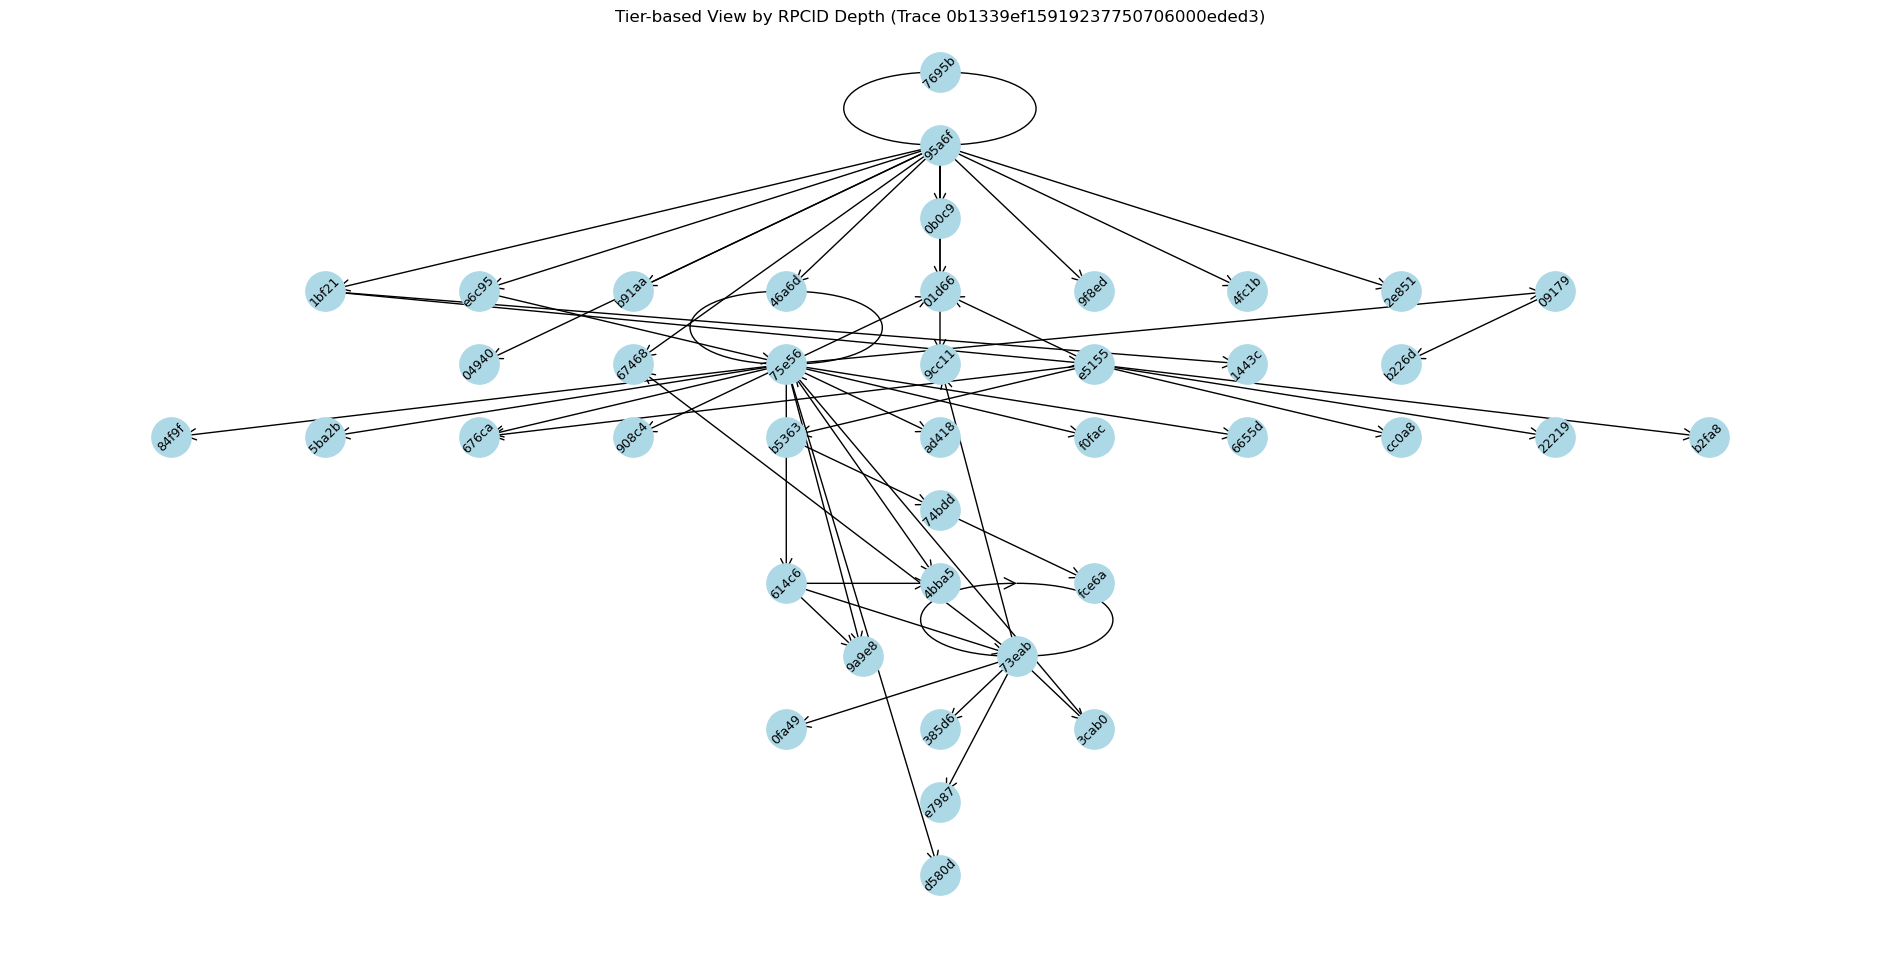

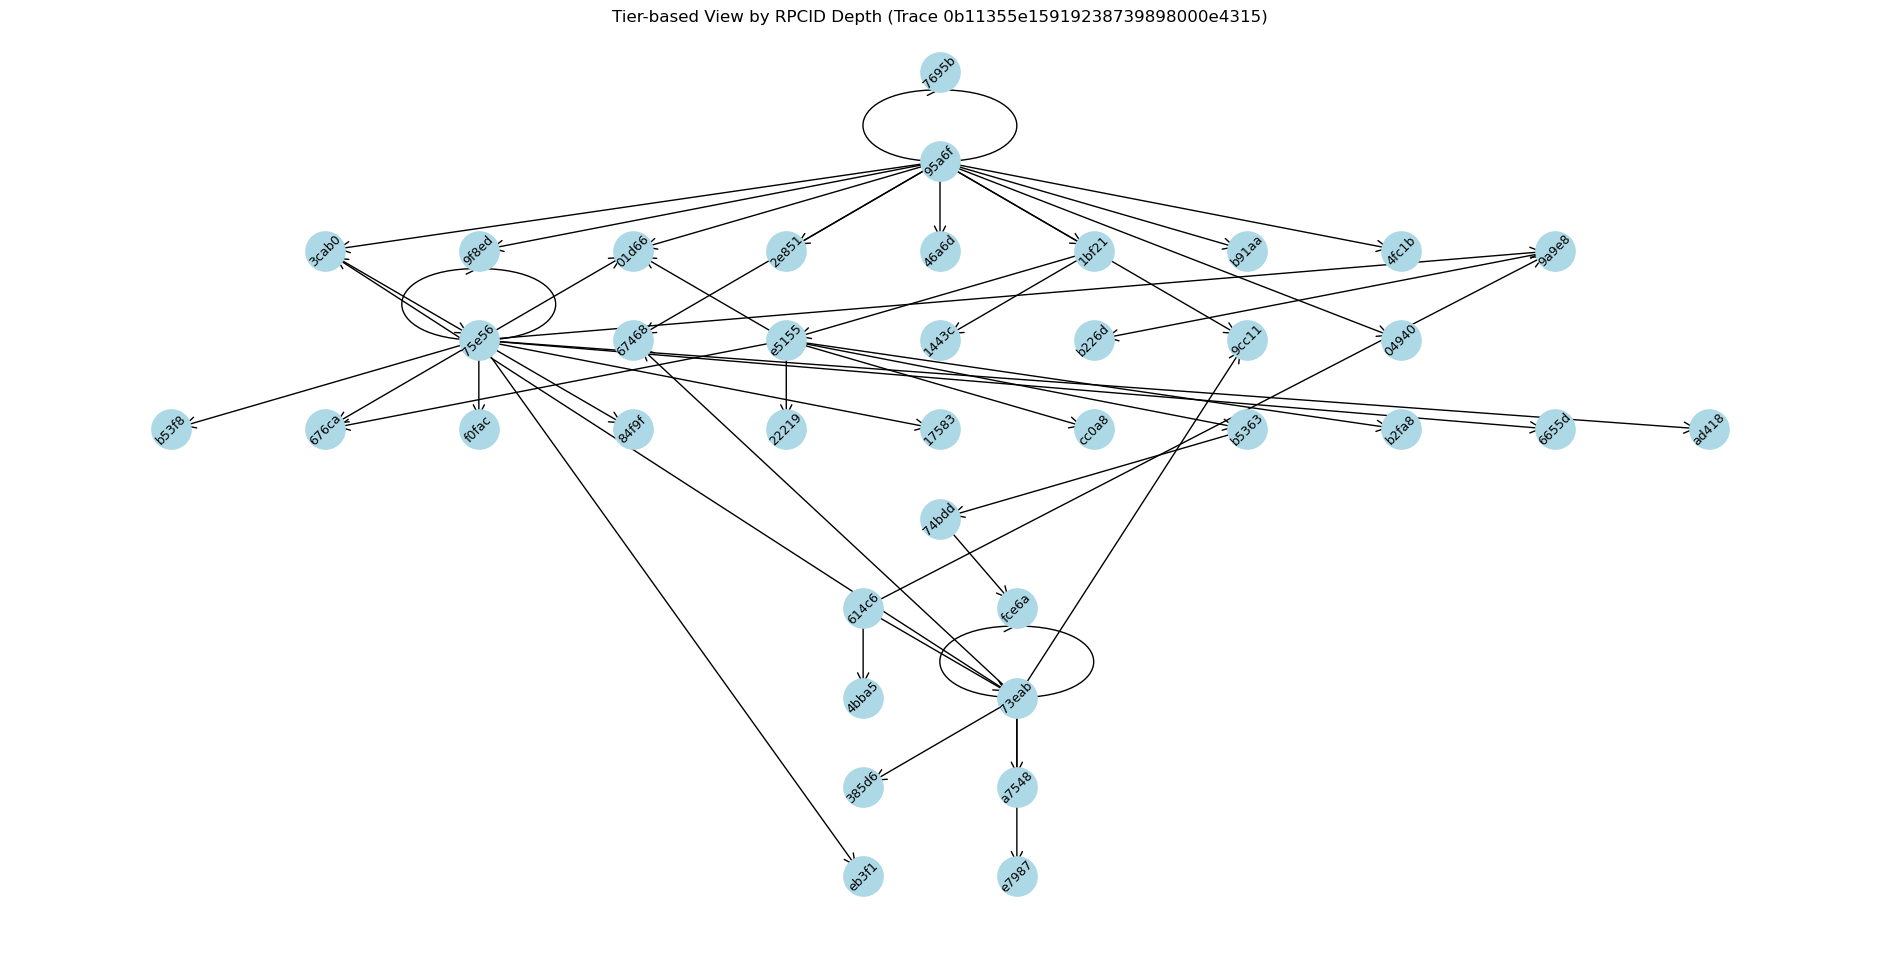

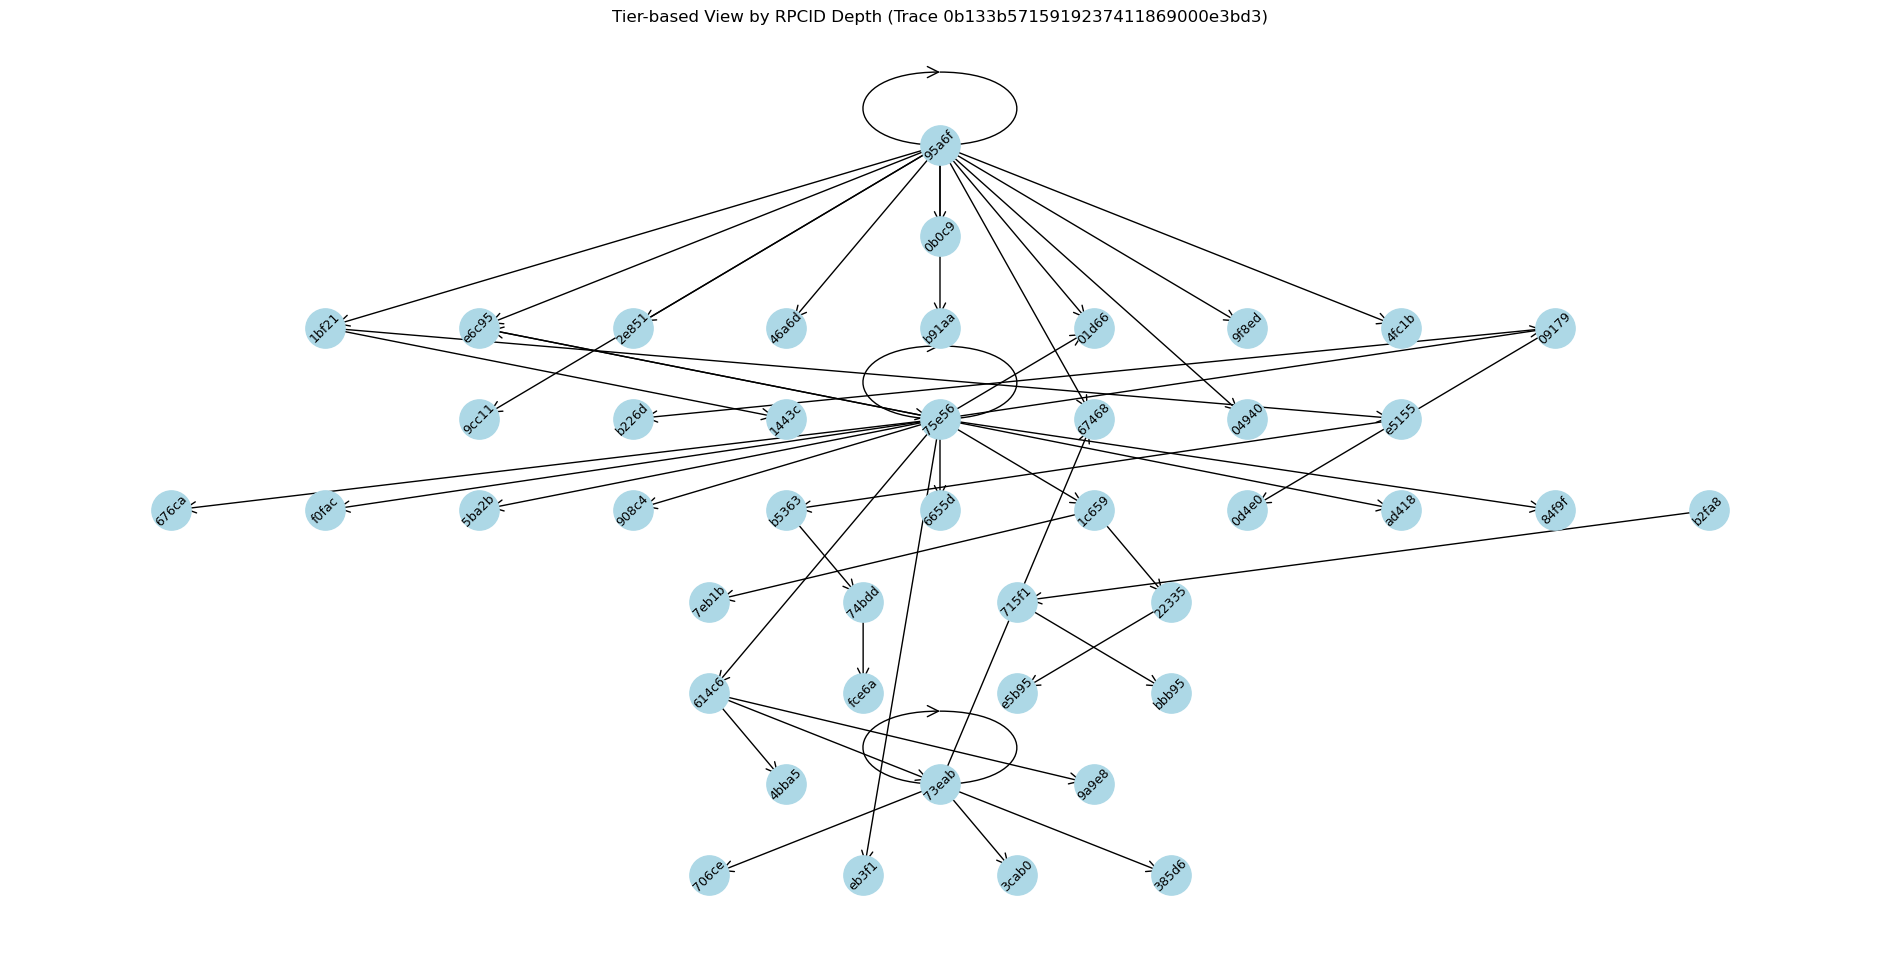

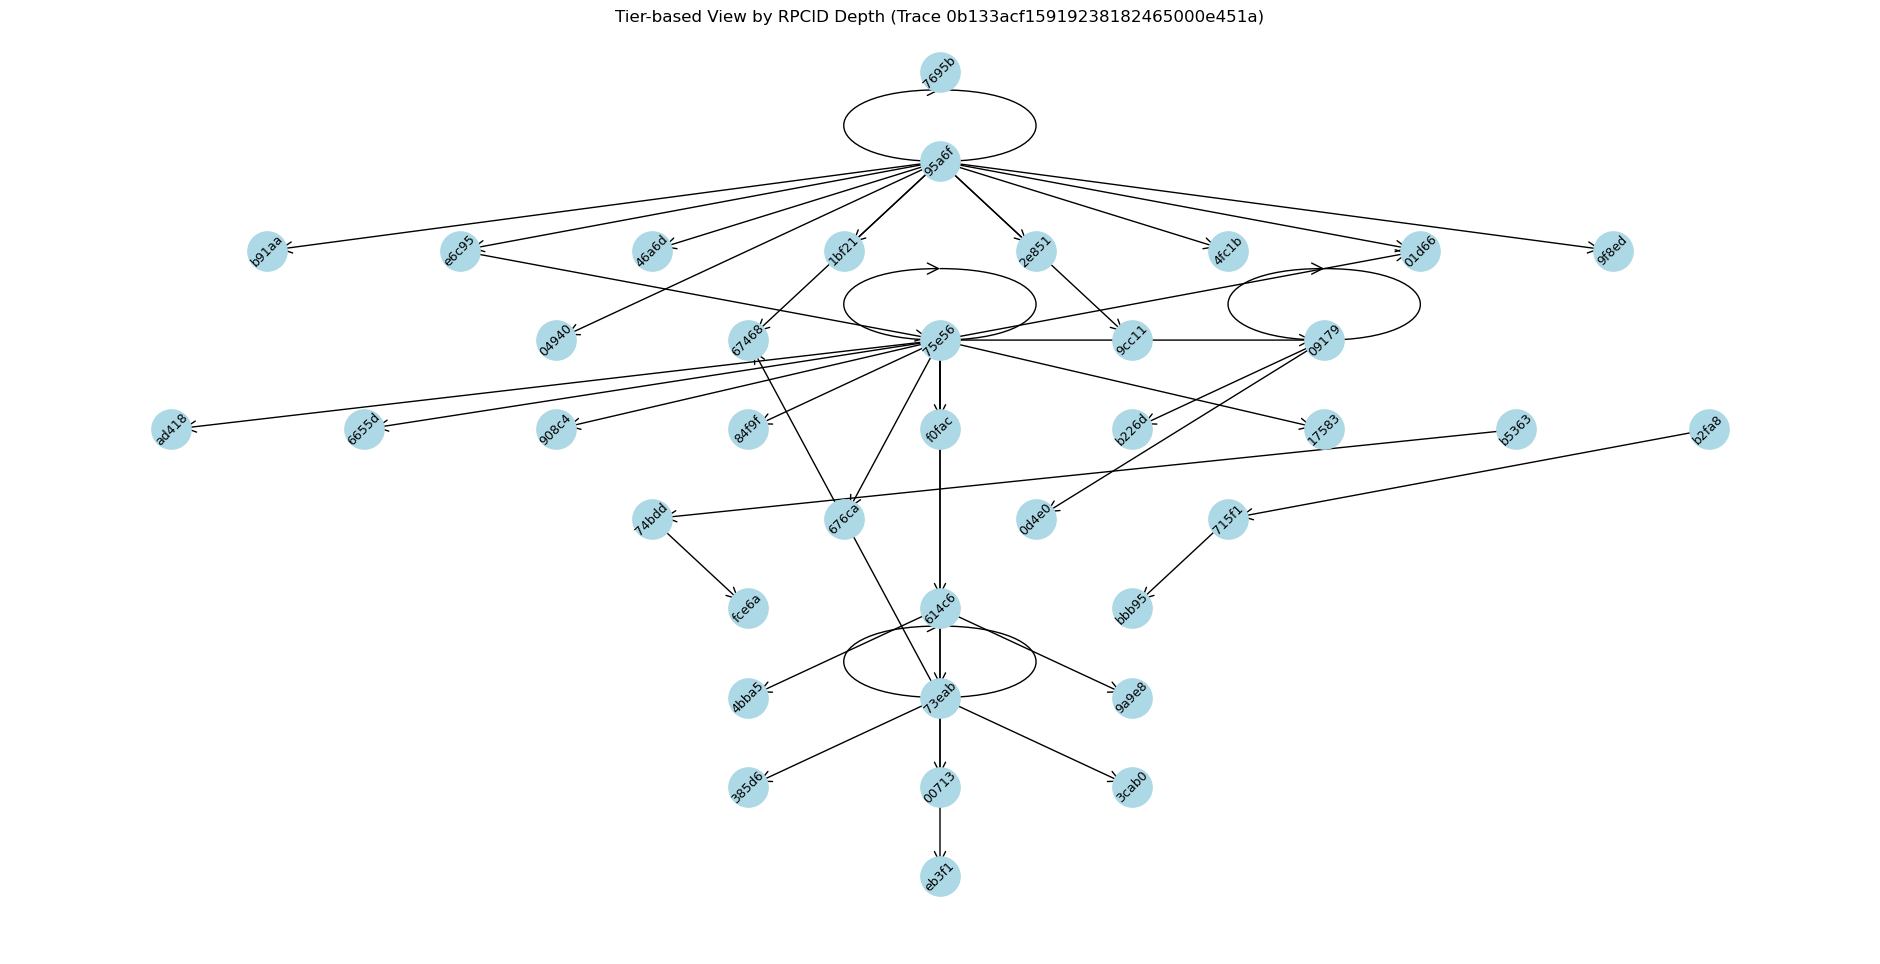

In [59]:
[create_tiered_graph_by_rpcid(df=df, trace_id=traceids[i], draw=True) for i in labels_and_graph_indexes[0]]
print()